# Titanic — Machine Learning from Disaster

## Modeling

This notebook covers feature engineering, model training and evaluation (Random Forest and SVC examples), and generating predictions for submission.

## Setup

In [23]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from src.data_processing import load_processed_data, save_submission_data
from src.feature_engineering import encode_features, generate_features

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Load Processed Data

Load the cleaned datasets from the previous processing step:

In [24]:
PROCESSED_TRAIN_FILENAME = "train.csv"
PROCESSED_TEST_FILENAME = "test.csv"

train_df = load_processed_data(PROCESSED_TRAIN_FILENAME)
test_df = load_processed_data(PROCESSED_TEST_FILENAME)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape:  {test_df.shape}")

train.csv successfully loaded from /Users/boramiklosbence/Documents/GitHub/vdn8wh-kutmod/02_assignment/notebooks/../data/processed/train.csv.
test.csv successfully loaded from /Users/boramiklosbence/Documents/GitHub/vdn8wh-kutmod/02_assignment/notebooks/../data/processed/test.csv.
Train data shape: (891, 11)
Test data shape:  (418, 10)


## Feature Engineering

Create new features and encode categorical variables:

In [25]:
train_features = generate_features(train_df)
test_features = generate_features(test_df)

print(f"Training features shape: {train_features.shape}")
print(f"Test feature shape: {test_features.shape}")

Training features shape: (891, 16)
Test feature shape: (418, 15)


## Encode Categorical Variables

Convert categorical features to numerical format:

In [26]:
train_encoded_df, test_encoded_df, encoders_dict = encode_features(train_features, test_features)

print(f"Encoded columns: {list(encoders_dict.keys())}")

Encoded columns: ['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin']


## Prepare Features and Target

Select features for modeling and separate target variable:

In [27]:
# Drop columns not needed for modeling
drop_columns = ["PassengerId", "Name", "Ticket", "Survived"]
feature_columns = [col for col in train_encoded_df.columns if col not in drop_columns]

# Prepare training data
x_features = train_encoded_df[feature_columns]
y_target = train_encoded_df["Survived"]

# Prepare test data
x_test_features = test_encoded_df[feature_columns]
test_passenger_ids = test_encoded_df["PassengerId"]

## Train-Validation Split

Split the training data for model evaluation:

In [28]:
x_train_split, x_val_split, y_train_split, y_val_split = train_test_split(x_features, y_target, test_size=0.2, random_state=RANDOM_SEED, stratify=y_target)

print(f"Training set: {x_train_split.shape}")
print(f"Validation set: {x_val_split.shape}")

print(f"\nTraining set target distribution:")
print(y_train_split.value_counts())

print(f"\nValidation set target distribution:")
print(y_val_split.value_counts())

Training set: (712, 12)
Validation set: (179, 12)

Training set target distribution:
Survived
0    439
1    273
Name: count, dtype: int64

Validation set target distribution:
Survived
0    110
1     69
Name: count, dtype: int64


## Random Forest Model

Train an initial Random Forest model with default parameters:

In [29]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_SEED
)
rf_model.fit(x_train_split, y_train_split)

# Predictions
y_train_pred_labels = rf_model.predict(x_train_split)
y_val_pred_labels = rf_model.predict(x_val_split)

# Evaluation
train_acc = accuracy_score(y_train_split, y_train_pred_labels)
val_acc = accuracy_score(y_val_split, y_val_pred_labels)

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"\nValidation Classification Report:")
print(classification_report(y_val_split, y_val_pred_labels, target_names=["Not Survived", "Survived"]))

Training Accuracy: 0.9508
Validation Accuracy: 0.8156

Validation Classification Report:
              precision    recall  f1-score   support

Not Survived       0.83      0.88      0.85       110
    Survived       0.79      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.82      0.81       179



### Support Vector Classifier Evaluation

We also train a Support Vector Classifier to test how a non-linear model performs on the validation split:


In [30]:
svc = SVC(probability=True)
svc.fit(x_train_split, y_train_split)

svc_val_pred = svc.predict(x_val_split)

svc_acc = accuracy_score(y_val_split, svc_val_pred)
print(f"SVC Validation Accuracy: {svc_acc:.4f}")

SVC Validation Accuracy: 0.6257


## Feature Importance Analysis

Analyze which features are most important for the model:

Feature Importance:


,Feature,Importance
1,Sex,0.246634
5,Fare,0.192316
2,Age,0.143136
9,Title,0.115482
0,Pclass,0.079044
7,FamilySize,0.053339
11,FareBin,0.039883
3,SibSp,0.034179
10,AgeBin,0.031846
6,Embarked,0.031379


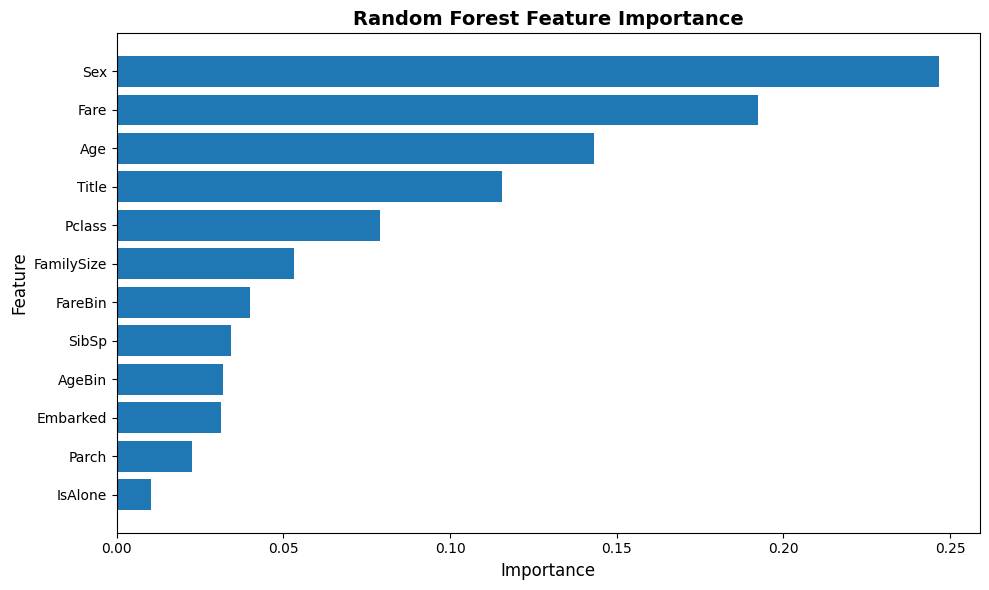

In [31]:
feature_importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": rf_model.feature_importances_}
).sort_values("Importance", ascending=False)

print("Feature Importance:")
display(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"])
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Random Forest Feature Importance", fontsize=14, fontweight="bold")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Generate Predictions for Test Set

Make predictions on the test set and prepare submission file:

In [32]:
# Generate predictions
test_pred_labels = rf_model.predict(x_test_features)

# Create submission dataframe
submission_df = pd.DataFrame({"PassengerId": test_passenger_ids, "Survived": test_pred_labels})

print(f"\nPrediction distribution:")
print(submission_df["Survived"].value_counts())


Prediction distribution:
Survived
0    269
1    149
Name: count, dtype: int64


## Save Predictions

Save the predictions to a CSV file:

In [33]:
save_submission_data(submission_df, "result.csv")

result.csv successfully saved to /Users/boramiklosbence/Documents/GitHub/vdn8wh-kutmod/02_assignment/notebooks/../data/submission/result.csv
